In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
from pymatgen.io.cif import CifParser,CifWriter
import numpy as np
from pymatgen.core import Lattice

def transform(a_reduce=0.87,angle=-180,phi=0,move=0.93):
    parser = CifParser("../data/dipoles1.cif")
    structure = parser.get_structures()[0]
    coord = structure.cart_coords[3]+structure.cart_coords[5]+structure.cart_coords[6]+structure.cart_coords[8]
    coord=coord/4
    coord[2]=coord[2]*move
    new_a=structure.lattice.a*a_reduce

    structure.rotate_sites([3,5,6,8],np.deg2rad(angle),[0,1,0],coord)
    
    structure.rotate_sites([3,5,6,8],np.deg2rad(phi),[1,0,0],coord)
    structure

    #print structure
    lattice = Lattice.from_parameters(a=new_a, b=structure.lattice.b, c=structure.lattice.c, alpha=90,
                                      beta=structure.lattice.beta, gamma=90)
    # structure.modify_lattice(lattice)
    structure.lattice = lattice
    return structure

def get_mean_distance(structure):
    k=6
    val1=[]
    val2=[]
    dist1=[]
    dist2=[]
    for i in structure.get_neighbors(structure[2],10):
            if i[0].species_string=="Cl":
                dist1.append(i[1])
    val1.append(np.sort(dist1)[:k])
    for i in structure.get_neighbors(structure[3],10):
            if i[0].species_string=="Cl":
                dist2.append(i[1])
    val2.append(np.sort(dist2)[:k])
    return np.mean([val1,val2])

def get_mean_distance_angle(theta,phi):
    structure=transform(a_reduce=1,angle=theta,phi=phi,move=1)
    return get_mean_distance(structure)

In [23]:
theta=325
phi=180
s=transform(a_reduce=0.87,angle=theta,phi=phi,move=0.93)
CifWriter(s).write_file(f"../data/system_{theta}_{phi}.cif")

In [3]:
def create_spehircal_mesh_points(n,start_from_zero=True):
    t=np.linspace(0,np.rad2deg(2*np.pi),n)
    p=np.linspace(0,np.rad2deg(np.pi),n)
    if not start_from_zero:
        t=np.linspace(0,np.rad2deg(2*np.pi),n)
        p=np.linspace(-np.rad2deg(np.pi/2),np.rad2deg(np.pi/2),n)
    return t,p

In [41]:
nk=41
t,p=create_spehircal_mesh_points(nk)
angles_distance=np.array([get_mean_distance_angle(theta=i,phi=j) for i in t for j in p]).reshape(nk,nk)
# angles_distance=pickle.load(open("../data/angles_nn_distance.pickle", "rb"))
LJpotential=lambda eps,r0: eps*((r0/angles_distance)**12 - (r0/angles_distance)**6)

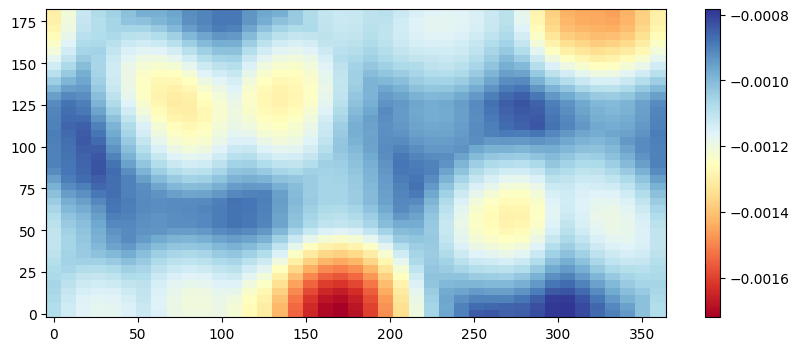

In [5]:
LJpotential=lambda eps,r0: eps*((r0/angles_distance)**12 - (r0/angles_distance)**6)
fig,ax=plt.subplots(1,1,figsize=(10,4))
plt.pcolor(t,p,LJpotential(1,1).T,cmap="RdYlBu",shading="auto")
plt.colorbar()


In [44]:
# import sys;sys.path.append("../")
# from utils import get_U_equation
# import sympy as sp
# Uz_symbolic,[t1,p1,t2,p2]=get_U_equation('z')
# P1={t1:0,p1:0} #Spin 1 pointing along z axis
# Uz=sp.lambdify((t2,p2),Uz_symbolic.subs(P1))
# dipole_z=np.array([Uz(j,i) for i in np.deg2rad(p) for j in np.deg2rad(t)]).reshape(nk,nk)



import sys;sys.path.append("../")
from utils import get_U_equation
import sympy as sp
Ux_symbolic,[t1,p1,t2,p2]=get_U_equation('x')
Uy_symbolic,[t1,p1,t2,p2]=get_U_equation('y')
Uz_symbolic,[t1,p1,t2,p2]=get_U_equation('z')

P1={t1:0,p1:0} #Spin 1 pointing along z axis
Uz=sp.lambdify((t2,p2),Uz_symbolic.subs(P1))
Usame=sp.lambdify((t2,p2),Ux_symbolic.subs({t1:t2,p1:p2}))

angles=np.linspace(0,2*np.pi,nk)
dipole_z=np.array([Uz(j,i)+Usame(j,i) for i in np.deg2rad(p) for j in np.deg2rad(t)]).reshape(nk,nk)

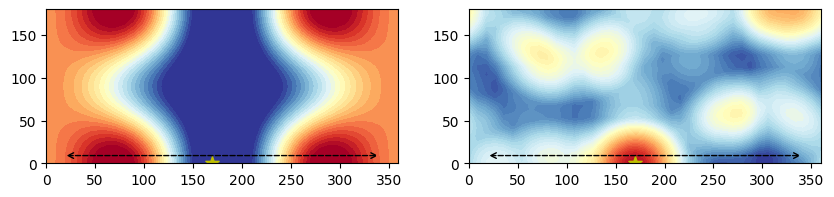

In [45]:
import matplotlib.patches as patches
p1 = patches.FancyArrowPatch((0, 0), (0, 1), arrowstyle='->', mutation_scale=20)

fig,ax=plt.subplots(1,2,figsize=(10,2))


ax[0].contourf(t,p,dipole_z,40,cmap="RdYlBu",vmin=-2,vmax=2)
ax[1].contourf(t,p,LJpotential(1,1).T,50,cmap="RdYlBu")

for i in ax:
    i.annotate('', xy=(.95, 0.05), xycoords='axes fraction', xytext=(.05, 0.05), 
            arrowprops=dict(arrowstyle="<->", color='k',lw=1,ls="--"))
    i.scatter(170,0,s=100,marker="*",color="y")

In [8]:
def min_max_scale(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

data={0.0:[-25817.651985, 3.59662],
20.0:[-25817.6519622, 3.60272],
40.0:[-25817.6514051, 3.5833],
60.0:[-25817.6516298, 3.6026],
80.0:[-25817.6371833, 3.39987],
100.0:[-25817.5815433, 3.22884],
120.0:[-25817.4892366, 2.44018],
140.0:[-25817.5031785, 2.467],
160.0:[-25817.6212143, 2.5132],
180.0:[-25817.6438885, 2.50503],
220.0:[-25817.6157228, 2.97102],
240.0:[-25817.6005773, 3.01634],
260.0:[-25817.6101179, 2.98198]}

x=np.array(list(data.keys()))
y=np.array(list(data.values()))[:,0]
y=(y-np.min(y))*13.6056980659 
y1=np.array(list(data.values()))[:,1]

dz_points=np.array([get_mean_distance_angle(theta=i,phi=0) for i in x])
uz=min_max_scale([Uz(i,0) for i in np.deg2rad(x)])
dz=lambda eps,r0:eps*((r0/dz_points)**12 - (r0/dz_points)**6)


E1=lambda beta,eps,r0:(-uz+dz(eps,r0))+beta

from scipy.optimize import minimize
def cost(x):
    return np.linalg.norm(E1(*x)-y1)

res=minimize(cost,x0=[.4,2,3],method="SLSQP",options={"maxiter":1000})

/Users/santy/miniconda/envs/dft/lib/python3.8/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


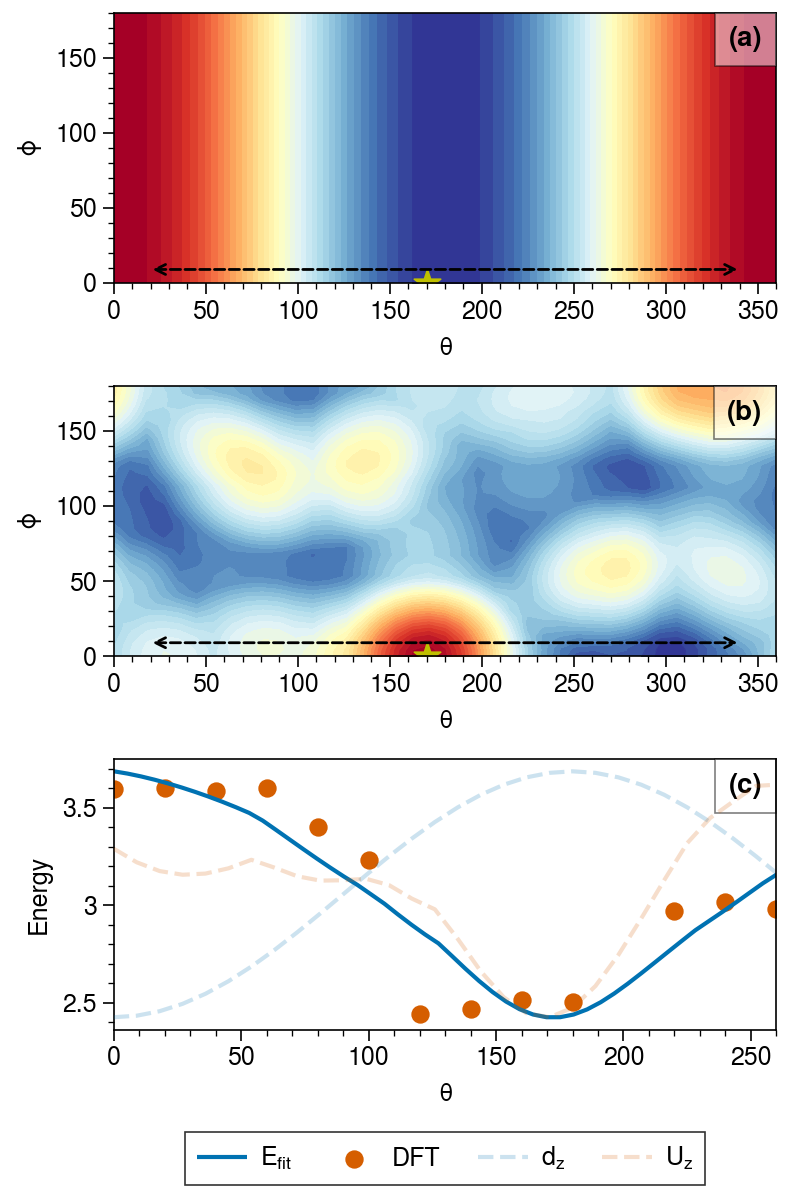

In [9]:
import proplot as pplt
pplt.rc.reset()
pplt.rc.update(grid=False, titleloc='uc')
fig, ax = pplt.subplots([[1],[2],[3]],share=False,figsize=(4,6))
fig.patch.set_facecolor('w')
ax.format(
    abc='(a)', abcloc='upper right',abcbbox=True
)

ax[0].contourf(t,p,dipole_z,cmap="RdYlBu",N=40)
ax[:2].format(ylabel="$\\phi$")
ax[1].contourf(t,p,LJpotential(1,1).T,cmap="RdYlBu",N=40)
ax[:2].format(xlabel="$\\theta$")

def min_max_scale(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))



xnew=np.linspace(0.1,x[-1],50)
dznew=np.array([get_mean_distance_angle(theta=i,phi=0) for i in xnew])
uznew=min_max_scale([Uz(i,0) for i in np.deg2rad(xnew)])
m=[]

[beta,eps,r0]=res.x
fitted_curve=-uznew+eps*((r0/dznew)**12 - (r0/dznew)**6)+beta
r=ax[2].plot(xnew,fitted_curve,label="$E_{fit}$")
m.append(r)

r=ax[2].scatter(x,y1,label="DFT")
m.append(r)
ax[2].format(xlabel="$\\theta$",ylabel="Energy")

axnew=ax[2].twinx()
r=axnew.plot(t,min_max_scale(dipole_z[0]),label="$d_z$",alpha=0.2,ls="--")
m.append(r)
r=axnew.plot(t,min_max_scale(LJpotential(1,1).T[0]),label="$U_z$",alpha=0.2,ls="--")
m.append(r)
axnew.format( yticks='null')
axnew.format(xlim=(0,x[-1]))

fig.legend(m, ncols=4, frame=True, loc='b')
for i in ax[:2]:
    i.annotate('', xy=(.95, 0.05), xycoords='axes fraction', xytext=(.05, 0.05), 
            arrowprops=dict(arrowstyle="<->", color='k',lw=1,ls="--"))
    i.scatter(170,0,s=100,marker="*",color="y")

# plt.savefig("../figures/fitted_curve.png",dpi=300)

In [10]:
nk=41
t,p=create_spehircal_mesh_points(nk)
angles_distance=np.array([get_mean_distance_angle(theta=i,phi=j) for i in t for j in p]).reshape(nk,nk).T

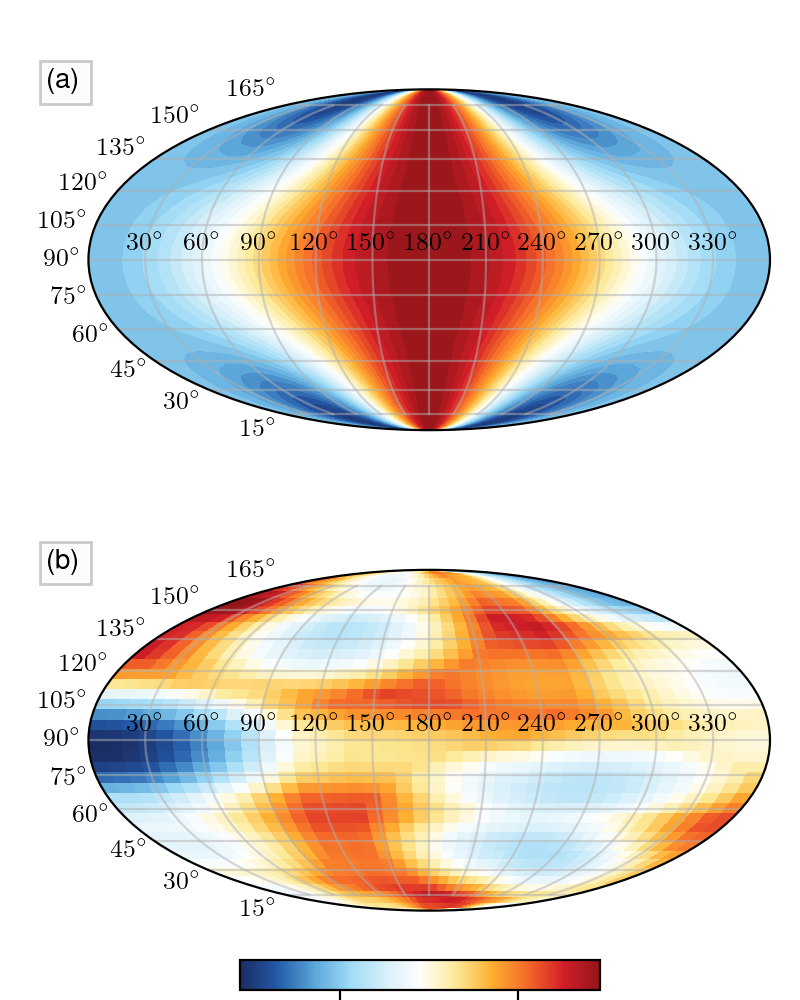

In [46]:
import matplotlib
import proplot as pplt
import matplotlib.transforms as mtransforms

plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
fig, ax = plt.subplots(2,1,subplot_kw=dict(projection='mollweide'), figsize=(4,5))

x = np.linspace(-np.pi, np.pi, nk)
y = np.linspace(-np.pi/2, np.pi/2, nk)
X, Y = np.meshgrid(x, y)

ax[0].contourf(X,Y, dipole_z,40,cmap=pplt.Colormap('ColdHot'),latlon=True)

im=ax[1].pcolormesh(X,Y, angles_distance,cmap=pplt.Colormap('ColdHot'))

matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
for i in ax:
    matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
    xlabels = ['$30^\circ$', '$60^\circ$','$90^\circ$','$120^\circ$','$150^\circ$',
                '$180^\circ$', '$210^\circ$', '$240^\circ$', '$270^\circ$','$300^\circ$', '$330^\circ$']

    ylabels = ['$165^\circ$', '$150^\circ$', '$135^\circ$', '$120^\circ$', 
                '$105^\circ$', '$90^\circ$', '$75^\circ$', '$60^\circ$',
                '$45^\circ$','$30^\circ$','$15^\circ$']
    ylabels.reverse()
    i.set_xticklabels(xlabels, fontsize=9)
    i.set_yticklabels(ylabels, fontsize=9)
    i.grid(alpha=0.5)


for j,i in enumerate(ax):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-.2, .1, fig.dpi_scale_trans)
    i.text(0.0, 1.0, ["(a)","(b)"][j], transform=i.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='.94', edgecolor='k',alpha=0.2, pad=3.0))

cax = fig.add_axes([0.3, .01, 0.45, 0.03])
fig.colorbar(im,orientation='horizontal', shrink=.5, cax=cax).set_label(label="Relative Strength",size=10)



plt.tight_layout()
fig.savefig('../figures/main_figure.png',dpi=300, bbox_inches='tight')

In [47]:
from scipy.optimize import minimize


data={0.0:[-25817.651985, 3.59662],
20.0:[-25817.6519622, 3.60272],
40.0:[-25817.6514051, 3.5833],
60.0:[-25817.6516298, 3.6026],
80.0:[-25817.6371833, 3.39987],
100.0:[-25817.5815433, 3.22884],
120.0:[-25817.5792366, 2.44018],
140.0:[-25817.5831785, 2.467],
160.0:[-25817.6212143, 2.5132],
180.0:[-25817.6438885, 2.50503],
220.0:[-25817.6357228, 2.97102],
240.0:[-25817.6285773, 3.01634],
260.0:[-25817.6101179, 2.98198]}

x=np.array(list(data.keys()))
y=np.array(list(data.values()))[:,0]
y=(y-np.min(y))*13.6056980659 

In [50]:
from scipy import interpolate
compensate=40
X=np.linspace(x[0],x[-1],100)+compensate
u_intrep=interpolate.interp1d(X, min_max_scale( [get_mean_distance_angle(theta=i,phi=0) for i in X]))
dipole=lambda theta: (Uz(np.deg2rad(theta+20),0)/2 +1)/2

In [51]:

from scipy.optimize import curve_fit
def energy_equation(x,a,b,c,d):
    return a*u_intrep(x+compensate)+b*dipole(x)+c+ \
            d*u_intrep(x+compensate)**2 # second order term for interaction

popt, pcov = curve_fit(energy_equation, x, y, p0=np.random.uniform(-.3,.3,4),method="lm",**{'ftol':1e-14,'xtol':1e-14})

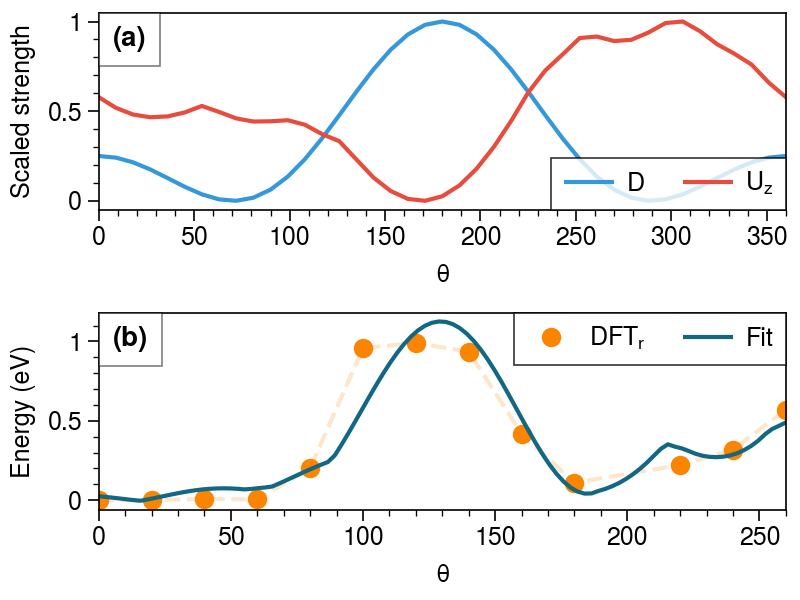

In [54]:
import proplot as pplt
pplt.rc.reset()
pplt.rc.update(grid=False,)
fig, ax = pplt.subplots([[1],[2]],share=False,figsize=(4,3))
fig.patch.set_facecolor('w')
ax.format(
    abc='(a)', abcloc='upper left',abcbbox=True
)


t=np.linspace(0,360,dipole_z[0].shape[0])
ax[0].plot(t,min_max_scale(dipole_z[0]),label="$D$",cycle='FlatUI')
ax[0].plot(t,min_max_scale( [get_mean_distance_angle(theta=i,phi=0) for i in t]),label="$U_z$",cycle='FlatUI')
ax[0].legend(loc="lower right")
ax[0].format(xlabel="$\\theta$",ylabel="Scaled strength")

def min_max_scale(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))


ax[1].plot(x,y,"--",color="#fb8500",alpha=0.2)
ax[1].plot(x,y,"o",label="DFT$_r$",color="#fb8500")
ax[1].format(xlabel="$\\theta$",ylabel="Energy (eV)")
ax[1].plot(X-compensate, energy_equation(X-compensate, *popt), 'r-',label="Fit",color="#126782")
ax[1].legend(loc="upper right")


fig.savefig('../figures/fit.png',dpi=300, bbox_inches='tight')

In [22]:
x_dot=62.5
y_dot=(-25817.6080602-np.min(y))*13.6056980659

x_dot1=345
y_dot1=(-25817.6326674-np.min(y))*13.6056980659

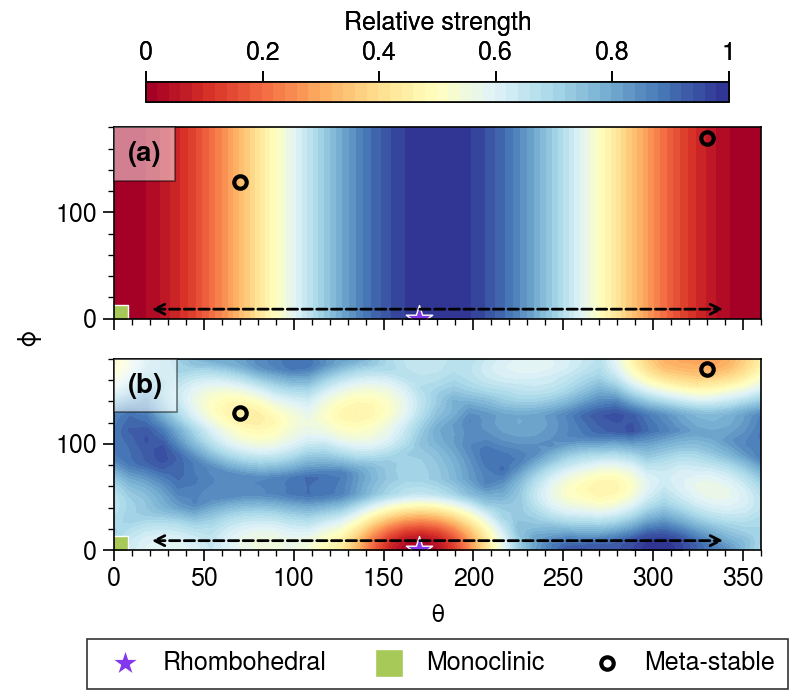

In [84]:
import proplot as pplt

def min_max_scale(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

pplt.rc.reset()
pplt.rc.update(grid=False, titleloc='uc')
fig, ax = pplt.subplots([[1],[2]],share=True,figsize=(4,3.5))
fig.patch.set_facecolor('w')
ax.format(
    abc='(a)', abcloc='upper left',abcbbox=True
)

ax[0].contourf(t,p,dipole_z,N=40,cmap="RdYlBu",vmin=-2,vmax=2)

r=ax[1].contourf(t,p, min_max_scale(LJpotential(1,1).T),N=50,cmap="RdYlBu")



for i in ax:i.format(ylabel="$\\phi$")
ax[1].format(xlabel="$\\theta$")
fig.colorbar(r, label='Relative strength', ticks=0.2, loc='t', length=0.9,width=0.1)


for i in ax:
    i.annotate('', xy=(.95, 0.05), xycoords='axes fraction', xytext=(.05, 0.05), 
            arrowprops=dict(arrowstyle="<->", color='k',lw=1,ls="--"))
    i.scatter(170,0,s=100,marker="*",color="#8338ec",label="Rhombohedral",edgecolor="w",lw=.5)
    i.scatter(0,0,s=100,marker="s",color="#a7c957",label="Monoclinic",edgecolor="w",lw=.5)
    for j,points in enumerate([[330,170],[70,129]]):
        i.scatter(*points,marker="o",s=20,edgecolor="k",facecolor="none",lw=1.5,label=[None,"Meta-stable"][j])

ax[1].legend(loc="b")
fig.savefig('../figures/main_figure_structures.png',dpi=300, bbox_inches='tight')
plt.show()